<a href="https://colab.research.google.com/github/jaredratto22/simulated_annealing_tsp/blob/main/simulated_annealing_tsp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instructions

I ran this in Google Colab, be sure to load all the .tsp files included in the repository before running.

Run the cells under the markdown sections "Define Classes of City and Route" and "Functions:" in order to run the experiments the cells that follow.

The runtime for Sample Size S is around 10 minutes based on its current parameters in the cell. The runtime for each experiment comparing the algorithms is about 3 minutes per benchmark problem.


Note: a fourth cooling schedule "linear multiplicative" was considered but is not used in the experiments because it behaved too similarly to the exponential multiplicative cooling schedule.

In [ ]:
import numpy as np
import random as random
import matplotlib.pyplot as plt

# Define Classes of City and Route

I was inspired by this [article](https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35) that defined cities and routes as classes (object oriented programming) in order to find the distance of a route. Credit: Eric Stotz


In [ ]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

In [ ]:
class Route:
    def __init__(self, route):
        self.route = route
        pathDistance = 0
        for i in range(0, len(self.route)):
          fromCity = self.route[i]
          toCity = None
          if i + 1 < len(self.route):
              toCity = self.route[i + 1]
          else:
              toCity = self.route[0]
          pathDistance += fromCity.distance(toCity)
        self.distance = pathDistance
        self.fitness = (1 / float(self.distance)) * 1000000

# Functions: Create Route, Swap, Simulated Annealing

In [ ]:
import random
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

In [ ]:
def swap_cities(old_route):
  swap_indices = random.sample(list(np.arange(len(old_route.route))),2)
  swap_index_0 = swap_indices[0]
  swap_index_1 = swap_indices[1]

  new_route = old_route.route.copy()

  new_route[swap_index_0] = old_route.route[swap_index_1]
  new_route[swap_index_1] = old_route.route[swap_index_0]

  route_copy = Route(new_route)

  return route_copy

### Find Initial Temperature

In [ ]:
def find_initial_temp(X_0, S_sample_size, p, eps, T_n= 1000):

# Parameter notes:
# X_0 : Your desired acceptance probability (e.g., 0.8)
# S_sample_size : The number of rows in array_e_min_max; ie, number of samples (pairs of e_min and e_max) to compute an estimation of the temperature that yields the desired acceptance probability X_0
# p : a parameter used in the recursive formula for changing the temp. A higher p results in a smaller change of temperature with each iteration. You iteratively to be closer to a temp that yields the desired acceptance probability
# eps: epsilon is the margin of error between X_hat_T_n and X_0 for determining when to stop the algorithm
# T_n is the temperature value at a given iteration. In function's parameters, set T_n to the temperature you want to start at

  def create_S(S_sample_size): # create a 2D array of multiple comparisons of two energy states. To find these two energy states, simply create 2 solutions and calculate their fitnesses. The solution with the lower fitness is e_min and the higher fitness is e_max. Energy is synonymous with cost. So a higher energy state is a worse solution
    array_e_min_max = np.empty((0,2))
    while len(array_e_min_max) < S_sample_size:
      route_0 = Route(createRoute(cities_list))
      route_1 = Route(createRoute(cities_list))
      if route_1.distance > route_0.distance:
        temp_list = [route_0.distance,route_1.distance]
        array_e_min_max = np.vstack((array_e_min_max,temp_list))
    return array_e_min_max

  def X_hat(T_n,e_mins,e_maxs): # Finds the approximated acceptance probability of the current temperature given our samples S
    numerator = np.sum(np.exp(-e_maxs/T_n))
    denominator = np.sum(np.exp(-e_mins/T_n))
    return numerator/denominator

  array_e_min_max = create_S(S_sample_size)
  X_hat_T_n = X_hat(T_n,array_e_min_max[:,0],array_e_min_max[:,1]) # Approximates accpetance probability of INITIAL temp

  while abs(X_hat_T_n - X_0) > eps:
    T_n = T_n * (( np.log(X_hat_T_n) / np.log(X_0) ) ** ( 1/p )) # Adjust temp with recursive formula. You iteratively adjust it to be closer to one that yields the desired acceptance probability
    X_hat_T_n = X_hat(T_n,array_e_min_max[:,0],array_e_min_max[:,1]) # Approximates accpetance probability of CURRENT temp

  return T_n

In [ ]:
def sample_size_experiment(sizes, array_iterations): # which value of S leads to the lowest 

# Function Parameters
# sizes : list of values of S_len you want to try. You could use np.arange to create this input
# array_iterations : For each value of S_len, how many times do you want to run the find_initial_temp function to test the standard deviation of each S value

  mean_array = np.empty(0)
  stdev_array = np.empty(0)

  for S_len in sizes:
    short_array = np.empty(0)

    for i in range(array_iterations):

      T_n = find_initial_temp(X_0 = 0.8, S_sample_size = S_len, p = 1.5, eps = 0.001)

      short_array = np.append(short_array,T_n)

    mean_array = np.append(mean_array,np.mean(short_array))
    stdev_array = np.append(stdev_array,np.std(short_array))

  return mean_array, stdev_array

# You're really more interested in the lowest element in st_dev array. Line that up with the sizes array to find the S value you should use

In [ ]:
def plot_sample_sizes(sizes, mean_array, stdev_array):

# Plotting the results of your sample_size_experiment. Mean_array is less valuable, you're more interested in the lowest value in stdev_array

  fig, ax1 = plt.subplots()
  color = 'darkgoldenrod'
  ax1.set_xlabel('S Size')
  ax1.set_ylabel('Avg Temperature', color=color)
  ax1.plot(sizes, mean_array, color=color)
  ax1.tick_params(axis='y', labelcolor=color)

  ax2 = ax1.twinx()

  color = 'royalblue'
  ax2.set_ylabel('StDev', color=color)
  ax2.plot(sizes, stdev_array, color=color)
  ax2.tick_params(axis='y', labelcolor=color)
  ax2.set_ylim(ymin=0)

  plt.grid()
  fig.tight_layout()
  
  return plt.show()

### Stochastic Hill Climbing

In [ ]:
def stochastic_hill_climbing(cities_list,n_iterations,random_seed=92):
  random.seed(random_seed)

  distances = np.empty(0)

  route_0 = Route(createRoute(cities_list))

  for i in range(n_iterations):
    route_1 = swap_cities(route_0)
    if route_1.distance < route_0.distance:
      route_0 = Route(route_1.route.copy())
    distances = np.append(distances,route_0.distance)
  
  return distances

In [ ]:
def stochastic_hill_climbing_seeds(cities_list,n_iterations,seeds):

  # Just like the previous function, but does so with multiple runs with multiple seeds
  # Then the output is the average distance (fitness) across all the runs for each iteration

  all_distances = np.empty((0,n_iterations))
  for seed in seeds:
    distances = stochastic_hill_climbing(cities_list,n_iterations,random_seed=seed)
    all_distances = np.vstack((all_distances,distances))

  avg_distances = np.mean(all_distances.copy(),axis=0)
  
  return avg_distances, all_distances[:,-1]

### Random Search

In [ ]:
def random_search(cities_list,n_iterations,random_seed=92):
  random.seed(random_seed)

  distances = np.empty(0)

  route_0 = Route(createRoute(cities_list))

  for i in range(n_iterations):
    route_1 = Route(createRoute(cities_list))
    if route_1.distance < route_0.distance:
      route_0 = Route(route_1.route.copy())
    distances = np.append(distances,route_0.distance)

  return distances

In [ ]:
def random_search_seeds(cities_list,n_iterations,seeds):

  # Just like the previous random search function, but does so with multiple runs with multiple seeds
  # Then the output is the average distance (fitness) across all the runs for each iteration

  all_distances = np.empty((0,n_iterations))
  for seed in seeds:
    distances = random_search(cities_list,n_iterations,random_seed=seed)
    all_distances = np.vstack((all_distances,distances))

  avg_distances = np.mean(all_distances.copy(),axis=0)

  return avg_distances, all_distances[:,-1]

### Plotting Progress of SA

In [ ]:
def simulated_annealing(cities_list,n_iterations, init_temp, cooling_schedule, random_seed=92):

  # Runs the simulated annealing algorithm once for one random seed
  
  random.seed(random_seed)

  distance_by_i = np.empty(0)
  temperature_by_i = np.empty(0)
  iterationz = np.arange(1,n_iterations+1)
  
  route_0 = Route(createRoute(cities_list))

  current_temp = init_temp
  for i in range(n_iterations):
    route_1 = swap_cities(route_0)
    if route_1.distance < route_0.distance:
      route_0 = Route(route_1.route.copy())
    elif random.random() <= np.exp(-( route_1.distance - route_0.distance) / current_temp ):
      route_0 = Route(route_1.route.copy())
    distance_by_i = np.append(distance_by_i,route_0.distance)

    # Temperature Cooling
    if cooling_schedule == "linear_additive":
      final_temp = 0.0000000005
      current_temp = final_temp + (init_temp - final_temp) * ( (n_iterations - i) / n_iterations )
    if cooling_schedule == "quadtratic_additive":
      final_temp = 0.0000000005
      current_temp = final_temp + (init_temp - final_temp) * ( (n_iterations - i) / n_iterations )**2
    if cooling_schedule == "linear_multiplicative":
      current_temp = init_temp/float(i + 1)
    if cooling_schedule == "exponential_multiplicative":
      alpha = 0.90
      current_temp = init_temp * alpha**i
    temperature_by_i = np.append(temperature_by_i,current_temp)
  
  return iterationz, distance_by_i, temperature_by_i

In [ ]:
def simulated_annealing_experiment(cities_list,n_iterations, init_temp, cooling_schedule, seeds=range(92,92+10)):
  
  # Just like the previous simulated_annealing function, but does so with multiple runs with multiple seeds
  # Then the output is the average distance (fitness) across all the runs for each iteration

  all_distances = np.empty((0,n_iterations))
  for seed in seeds:
    distances = simulated_annealing(cities_list,n_iterations, init_temp, cooling_schedule, random_seed=seed)[1]
    all_distances = np.vstack((all_distances,distances))


  avg_distances = np.mean(all_distances.copy(),axis=0)

  iterationz = simulated_annealing(cities_list,n_iterations, init_temp, cooling_schedule, random_seed=seed)[0]
  temperatures = simulated_annealing(cities_list,n_iterations, init_temp, cooling_schedule, random_seed=seed)[2]

  return avg_distances

In [ ]:
def simulated_annealing_plots(cities_list,n_iterations, init_temp, cooling_schedule, seeds=range(92,92+10)):

  # Just like the previous function but also outputs a plot

  all_distances = np.empty((0,n_iterations))
  for seed in seeds:
    distances = simulated_annealing(cities_list,n_iterations, init_temp, cooling_schedule, random_seed=seed)[1]
    all_distances = np.vstack((all_distances,distances))


  avg_distances = np.mean(all_distances.copy(),axis=0)

  iterationz = simulated_annealing(cities_list,n_iterations, init_temp, cooling_schedule, random_seed=seed)[0]
  temperatures = simulated_annealing(cities_list,n_iterations, init_temp, cooling_schedule, random_seed=seed)[2]

  fig, ax1 = plt.subplots()
  color = 'forestgreen'
  ax1.set_xlabel('S Size')
  ax1.set_ylabel('Distance', color=color)
  ax1.plot(iterationz, avg_distances, color=color)
  ax1.tick_params(axis='y')

  ax2 = ax1.twinx()

  color = 'red'
  ax2.set_ylabel('Temperature', color=color)
  ax2.plot(iterationz, temperatures, color=color)
  ax2.tick_params(axis='y')
  ax2.set_ylim(ymin=0)

  plt.grid()
  fig.tight_layout()

  return avg_distances

# Visualizing Cooling Schedules
I compare 3 schedules

In [ ]:
# Open input file
infile = open('berlin52.tsp', 'r')

# Read instance header
Name = infile.readline().strip().split()[1] # NAME
FileType = infile.readline().strip().split()[1] # TYPE
Comment = infile.readline().strip() # COMMENT
Dimension = infile.readline().strip().split()[-1] # DIMENSION
EdgeWeightType = infile.readline().strip().split()[1] # EDGE_WEIGHT_TYPE
infile.readline()

# Read node list
nodes_reference = []
intDimension = int(Dimension)
for i in range(0, int(intDimension)):
    x,y = infile.readline().strip().split()[1:]
    nodes_reference.append([float(x), float(y)])

# Close input file
infile.close()
nodes_reference = np.asarray(nodes_reference) # Index of the node is the node's number (starting at 0)

In [ ]:
cities_list = []

for i in range(0,len(nodes_reference)):
  cities_list.append(City(x=nodes_reference[i,0], y=nodes_reference[i,1]))
len(cities_list)

52

## Linear Additive

array([29705.07717153, 29730.44399189, 29607.17686569, ...,
       18753.39280197, 18753.39280197, 18749.2466391 ])

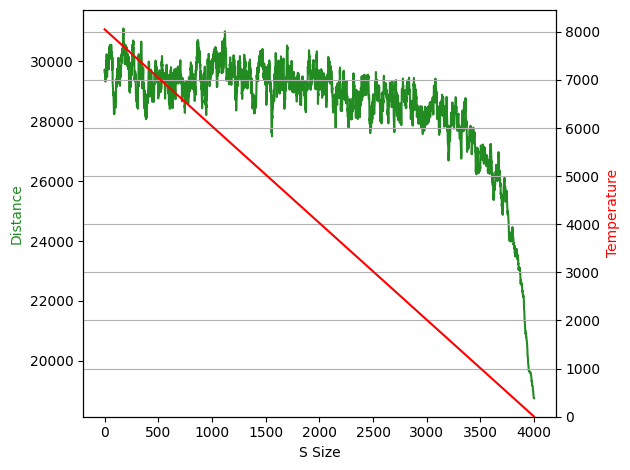

In [ ]:
simulated_annealing_plots(cities_list=cities_list,n_iterations=4000, init_temp=8050, cooling_schedule="linear_additive", seeds=range(92,92+10))

## Quadratic Additive

array([29705.07717153, 29730.44399189, 29607.17686569, ...,
       13859.59383257, 13859.59383257, 13859.59383257])

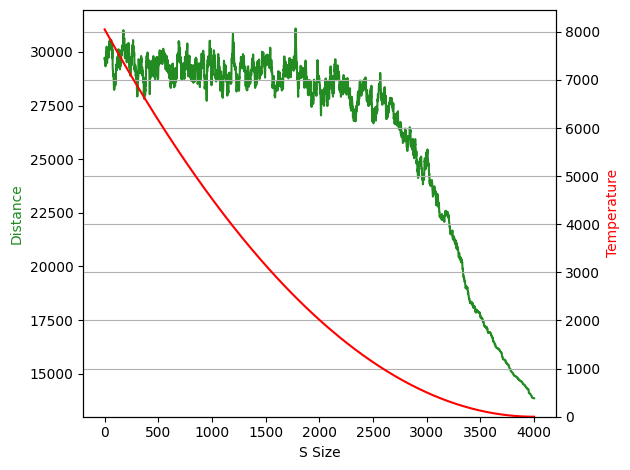

In [ ]:
simulated_annealing_plots(cities_list=cities_list,n_iterations=4000, init_temp=8050, cooling_schedule="quadtratic_additive", seeds=range(92,92+10))

## Exponential Multiplicative

array([29705.07717153, 29730.44399189, 29607.17686569, ...,
       11250.2924732 , 11250.2924732 , 11250.2924732 ])

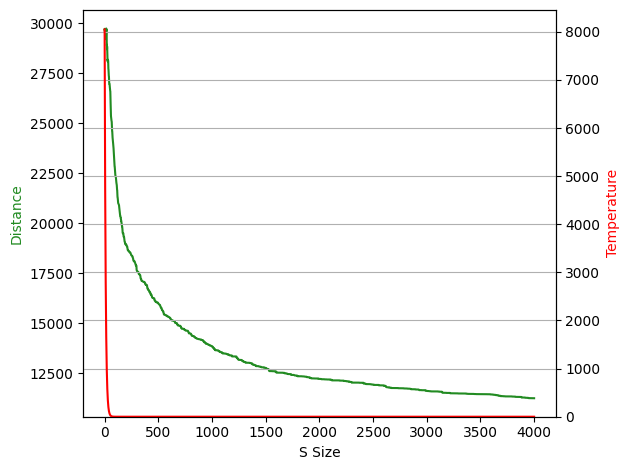

In [ ]:
simulated_annealing_plots(cities_list=cities_list,n_iterations=4000, init_temp=8050, cooling_schedule="exponential_multiplicative", seeds=range(92,92+10))

# Experiment of Compared Algorithms

## Berlin52

### Load Data

In [ ]:
# Open input file
infile = open('berlin52.tsp', 'r')

# Read instance header
Name = infile.readline().strip().split()[1] # NAME
FileType = infile.readline().strip().split()[1] # TYPE
Comment = infile.readline().strip() # COMMENT
Dimension = infile.readline().strip().split()[-1] # DIMENSION
EdgeWeightType = infile.readline().strip().split()[1] # EDGE_WEIGHT_TYPE
infile.readline()

'NODE_COORD_SECTION\n'

In [ ]:
# Read node list
nodes_reference = []
intDimension = int(Dimension)
for i in range(0, int(intDimension)):
    x,y = infile.readline().strip().split()[1:]
    nodes_reference.append([float(x), float(y)])

# Close input file
infile.close()
nodes_reference = np.asarray(nodes_reference) # Index of the node is the node's number (starting at 0)

In [ ]:
cities_list = []

for i in range(0,len(nodes_reference)):
  cities_list.append(City(x=nodes_reference[i,0], y=nodes_reference[i,1]))

In [ ]:
len(cities_list)

52

### Find Initial Temperature

In this notebook, I have ran the experiment to find an optimal S value only for the Berlin52 dataset. The experiment can take about 10 minutes to run, and so I only ran it for one dataset and then scaled the value by the number of cities for larger datasets.

In [ ]:
s_sizes = np.arange(3000,6000+500,500)
s_experiment = sample_size_experiment(sizes=s_sizes, array_iterations=20)
mean_array = s_experiment[0]
stdev_array = s_experiment[1]
# Took 15 minutes to run

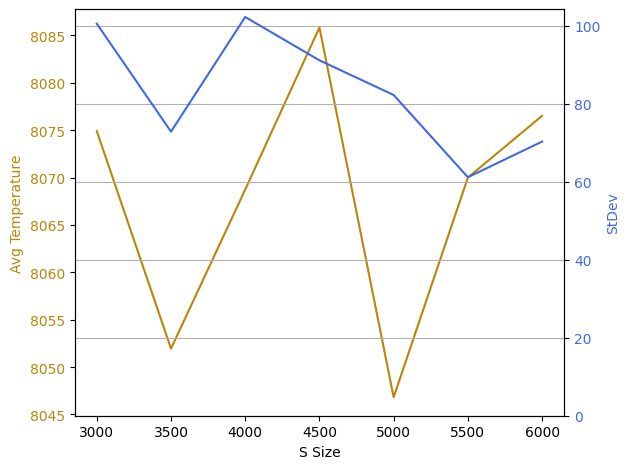

In [ ]:
plot_sample_sizes(sizes=s_sizes, mean_array=mean_array, stdev_array=stdev_array)


In [ ]:
# so S = 3000
initial_temp = find_initial_temp(X_0 = 0.8, S_sample_size=3000, p=1.5, eps = 0.001, T_n= 100)
initial_temp

7955.042518751509

### Plots

While find_initial_temp() is run for each dataset, I use the same cooling schedules each time because I found that linear additive was consistently inferior compared to the other two schedules.

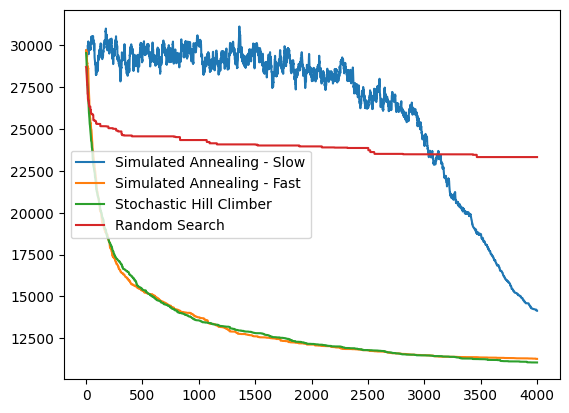

In [ ]:
iterationz = np.arange(1,4000+1)

sim_slow_distances = simulated_annealing_experiment(cities_list = cities_list,n_iterations = 4000, init_temp = initial_temp, cooling_schedule = "quadtratic_additive", seeds=range(92,92+10))

sim_fast_distances = simulated_annealing_experiment(cities_list = cities_list,n_iterations = 4000, init_temp = initial_temp, cooling_schedule = "linear_multiplicative", seeds=range(92,92+10))

stoch = stochastic_hill_climbing_seeds(cities_list,n_iterations = 4000, seeds=range(92,92+10))
stoch_distances = stoch[0]

randsearch = random_search_seeds(cities_list,n_iterations=4000,seeds=range(92,92+10))
randsearch_distances = randsearch[0]

plt.plot(iterationz,sim_slow_distances,label="Simulated Annealing - Slow")
plt.plot(iterationz,sim_fast_distances,label="Simulated Annealing - Fast")
plt.plot(iterationz,stoch_distances,label="Stochastic Hill Climber")
plt.plot(iterationz,randsearch_distances,label="Random Search")

plt.legend()

In [ ]:
print("Final Distances")
print(" ")
print("Slow Simulated Annealing:",int(sim_slow_distances[-1]))
print("Fast Simulated Annealing:",int(sim_fast_distances[-1]))
print("Stochastic Hill-Climber:",int(stoch_distances[-1]))
print("Random Search:",int(randsearch_distances[-1]))

14143
11267
11052
23329


## st70

### Load Data

In [ ]:
# Open input file
infile = open('st70.tsp', 'r')

# Read instance header
Name = infile.readline().strip().split()[1]
FileType = infile.readline().strip().split()[1]
Comment = infile.readline().strip()
Dimension = infile.readline().strip().split()[-1]
EdgeWeightType = infile.readline().strip().split()[1]
infile.readline()

# Read node list
nodes_reference = []
intDimension = int(Dimension)
for i in range(0, int(intDimension)):
    x,y = infile.readline().strip().split()[1:]
    nodes_reference.append([float(x), float(y)])

# Close input file
infile.close()
nodes_reference = np.asarray(nodes_reference) # Index of the node is the node's number (starting at 0)

In [ ]:
cities_list = []

for i in range(0,len(nodes_reference)):
  cities_list.append(City(x=nodes_reference[i,0], y=nodes_reference[i,1]))
len(cities_list)

70

### Find Initial Temperature

In [ ]:
S = round((intDimension / 52) * 3000)
initial_temp = find_initial_temp(X_0 = 0.8, S_sample_size=S, p=1.5, eps = 0.001, T_n= 100)
initial_temp

921.615102185554

### Plots

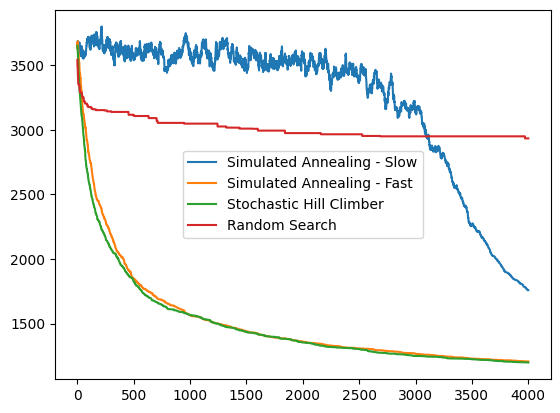

In [ ]:
iterationz = np.arange(1,4000+1)

sim_slow_distances = simulated_annealing_experiment(cities_list = cities_list,n_iterations = 4000, init_temp = initial_temp, cooling_schedule = "quadtratic_additive", seeds=range(92,92+10))
# sim_slow_distances = sim_anneal_slow[0]
# sim_t_test = sim_anneal_slow[1]

sim_fast_distances = simulated_annealing_experiment(cities_list = cities_list,n_iterations = 4000, init_temp = initial_temp, cooling_schedule = "linear_multiplicative", seeds=range(92,92+10))
# sim_fast_distances = sim_anneal_fast[0]
# sim_fast_t_test = sim_anneal_fast[1]

stoch = stochastic_hill_climbing_seeds(cities_list,n_iterations = 4000, seeds=range(92,92+10))
stoch_distances = stoch[0]
# stoch_t_test = stoch[1]

randsearch = random_search_seeds(cities_list,n_iterations=4000,seeds=range(92,92+10))
randsearch_distances = randsearch[0]
# randsearch_t_test = randsearch[1]

plt.plot(iterationz,sim_slow_distances,label="Simulated Annealing - Slow")
plt.plot(iterationz,sim_fast_distances,label="Simulated Annealing - Fast")
plt.plot(iterationz,stoch_distances,label="Stochastic Hill Climber")
plt.plot(iterationz,randsearch_distances,label="Random Search")

plt.legend()

In [ ]:
print("Final Distances")
print(" ")
print("Slow Simulated Annealing:",int(sim_slow_distances[-1]))
print("Fast Simulated Annealing:",int(sim_fast_distances[-1]))
print("Stochastic Hill-Climber:",int(stoch_distances[-1]))
print("Random Search:",int(randsearch_distances[-1]))

1758
1207
1198
2932


## eil101

### Load Data

In [ ]:
# Open input file
infile = open('eil101.tsp', 'r')

# Read instance header
Name = infile.readline().strip().split()[1] # NAME
FileType = infile.readline().strip().split()[1] # TYPE
Comment = infile.readline().strip() # COMMENT
Dimension = infile.readline().strip().split()[-1] # DIMENSION
EdgeWeightType = infile.readline().strip().split()[1] # EDGE_WEIGHT_TYPE
infile.readline()

'NODE_COORD_SECTION\n'

In [ ]:
# Read node list
nodes_reference = []
intDimension = int(Dimension)
for i in range(0, int(intDimension)):
    x,y = infile.readline().strip().split()[1:]
    nodes_reference.append([float(x), float(y)])

# Close input file
infile.close()
nodes_reference = np.asarray(nodes_reference) # Index of the node is the node's number (starting at 0)

In [ ]:
cities_list = []

for i in range(0,len(nodes_reference)):
  cities_list.append(City(x=nodes_reference[i,0], y=nodes_reference[i,1]))

In [ ]:
len(cities_list)

101

### Find Initial Temperature

In [ ]:
S = round((intDimension / 52) * 3000)
initial_temp = find_initial_temp(X_0 = 0.8, S_sample_size=6000, p=1.5, eps = 0.001, T_n= 100)
initial_temp

693.9063959339385

### Plots

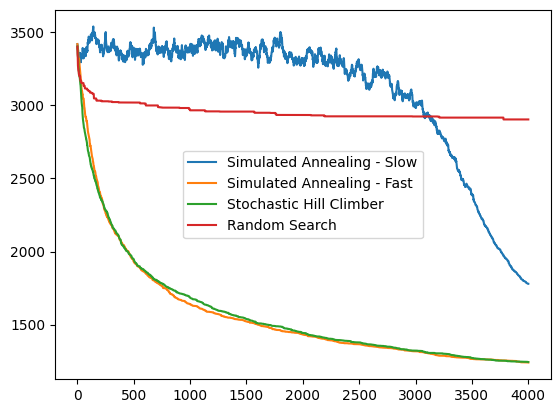

In [ ]:
iterationz = np.arange(1,4000+1)

sim_slow_distances = simulated_annealing_experiment(cities_list = cities_list,n_iterations = 4000, init_temp = initial_temp, cooling_schedule = "quadtratic_additive", seeds=range(92,92+10))
# sim_slow_distances = sim_anneal_slow[0]
# sim_t_test = sim_anneal_slow[1]

sim_fast_distances = simulated_annealing_experiment(cities_list = cities_list,n_iterations = 4000, init_temp = initial_temp, cooling_schedule = "linear_multiplicative", seeds=range(92,92+10))
# sim_fast_distances = sim_anneal_fast[0]
# sim_fast_t_test = sim_anneal_fast[1]

stoch = stochastic_hill_climbing_seeds(cities_list,n_iterations = 4000, seeds=range(92,92+10))
stoch_distances = stoch[0]
# stoch_t_test = stoch[1]

randsearch = random_search_seeds(cities_list,n_iterations=4000,seeds=range(92,92+10))
randsearch_distances = randsearch[0]
# randsearch_t_test = randsearch[1]

plt.plot(iterationz,sim_slow_distances,label="Simulated Annealing - Slow")
plt.plot(iterationz,sim_fast_distances,label="Simulated Annealing - Fast")
plt.plot(iterationz,stoch_distances,label="Stochastic Hill Climber")
plt.plot(iterationz,randsearch_distances,label="Random Search")

plt.legend()

In [ ]:
print("Final Distances")
print(" ")
print("Slow Simulated Annealing:",int(sim_slow_distances[-1]))
print("Fast Simulated Annealing:",int(sim_fast_distances[-1]))
print("Stochastic Hill-Climber:",int(stoch_distances[-1]))
print("Random Search:",int(randsearch_distances[-1]))

1779
1241
1244
2902


## ch130

### Load Data

In [ ]:
# Open input file
infile = open('ch130.tsp', 'r')

# Read instance header
Name = infile.readline().strip().split()[1] # NAME
FileType = infile.readline().strip().split()[1] # TYPE
Comment = infile.readline().strip() # COMMENT
Dimension = infile.readline().strip().split()[-1] # DIMENSION
EdgeWeightType = infile.readline().strip().split()[1] # EDGE_WEIGHT_TYPE
infile.readline()

# Read node list
nodes_reference = []
intDimension = int(Dimension)
for i in range(0, int(intDimension)):
    x,y = infile.readline().strip().split()[1:]
    nodes_reference.append([float(x), float(y)])

# Close input file
infile.close()
nodes_reference = np.asarray(nodes_reference) # Index of the node is the node's number (starting at 0)

In [ ]:
cities_list = []

for i in range(0,len(nodes_reference)):
  cities_list.append(City(x=nodes_reference[i,0], y=nodes_reference[i,1]))
len(cities_list)

130

### Find Initial Temperature

In [ ]:
S = round((intDimension / 52) * 3000)
initial_temp = find_initial_temp(X_0 = 0.8, S_sample_size=S, p=1.5, eps = 0.001, T_n= 100)
initial_temp

8281.413987357333

### Plots

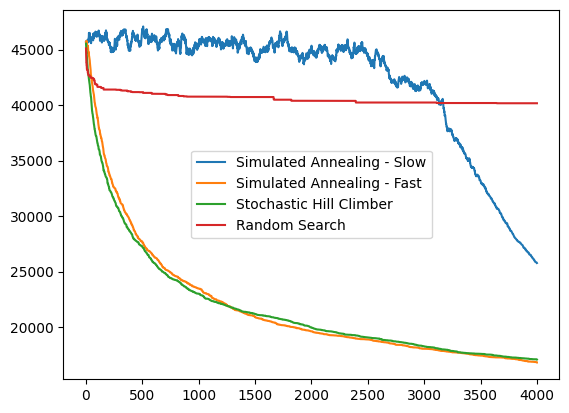

In [ ]:
iterationz = np.arange(1,4000+1)

sim_slow_distances = simulated_annealing_experiment(cities_list = cities_list,n_iterations = 4000, init_temp = initial_temp, cooling_schedule = "quadtratic_additive", seeds=range(92,92+10))
# sim_slow_distances = sim_anneal_slow[0]
# sim_t_test = sim_anneal_slow[1]

sim_fast_distances = simulated_annealing_experiment(cities_list = cities_list,n_iterations = 4000, init_temp = initial_temp, cooling_schedule = "linear_multiplicative", seeds=range(92,92+10))
# sim_fast_distances = sim_anneal_fast[0]
# sim_fast_t_test = sim_anneal_fast[1]

stoch = stochastic_hill_climbing_seeds(cities_list,n_iterations = 4000, seeds=range(92,92+10))
stoch_distances = stoch[0]
# stoch_t_test = stoch[1]

randsearch = random_search_seeds(cities_list,n_iterations=4000,seeds=range(92,92+10))
randsearch_distances = randsearch[0]
# randsearch_t_test = randsearch[1]

plt.plot(iterationz,sim_slow_distances,label="Simulated Annealing - Slow")
plt.plot(iterationz,sim_fast_distances,label="Simulated Annealing - Fast")
plt.plot(iterationz,stoch_distances,label="Stochastic Hill Climber")
plt.plot(iterationz,randsearch_distances,label="Random Search")

plt.legend()

In [ ]:
print("Final Distances")
print(" ")
print("Slow Simulated Annealing:",int(sim_slow_distances[-1]))
print("Fast Simulated Annealing:",int(sim_fast_distances[-1]))
print("Stochastic Hill-Climber:",int(stoch_distances[-1]))
print("Random Search:",int(randsearch_distances[-1]))

25780
16821
17089
40165


## a280

### Load Data

In [ ]:
# Open input file
infile = open('a280.tsp', 'r')

# Read instance header
Name = infile.readline().strip().split()[1] # NAME
FileType = infile.readline().strip().split()[1] # TYPE
Comment = infile.readline().strip() # COMMENT
Dimension = infile.readline().strip().split()[-1] # DIMENSION
EdgeWeightType = infile.readline().strip().split()[1] # EDGE_WEIGHT_TYPE
infile.readline()

# Read node list
nodes_reference = []
intDimension = int(Dimension)
for i in range(0, int(intDimension)):
    x,y = infile.readline().strip().split()[1:]
    nodes_reference.append([float(x), float(y)])

# Close input file
infile.close()
nodes_reference = np.asarray(nodes_reference) # Index of the node is the node's number (starting at 0)b

In [ ]:
cities_list = []

for i in range(0,len(nodes_reference)):
  cities_list.append(City(x=nodes_reference[i,0], y=nodes_reference[i,1]))
len(cities_list)

280

### Find Initial Temperature

In [ ]:
S = round((intDimension / 52) * 3000)
initial_temp = find_initial_temp(X_0 = 0.8, S_sample_size=S, p=1.5, eps = 0.001, T_n= 100)
initial_temp

4836.346013023382

### Plots

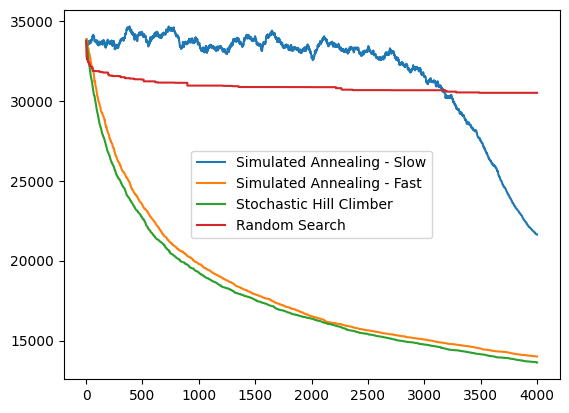

In [ ]:
iterationz = np.arange(1,4000+1)

sim_slow_distances = simulated_annealing_experiment(cities_list = cities_list,n_iterations = 4000, init_temp = initial_temp, cooling_schedule = "quadtratic_additive", seeds=range(92,92+10))
# sim_slow_distances = sim_anneal_slow[0]
# sim_t_test = sim_anneal_slow[1]

sim_fast_distances = simulated_annealing_experiment(cities_list = cities_list,n_iterations = 4000, init_temp = initial_temp, cooling_schedule = "linear_multiplicative", seeds=range(92,92+10))
# sim_fast_distances = sim_anneal_fast[0]
# sim_fast_t_test = sim_anneal_fast[1]

stoch = stochastic_hill_climbing_seeds(cities_list,n_iterations = 4000, seeds=range(92,92+10))
stoch_distances = stoch[0]
# stoch_t_test = stoch[1]

randsearch = random_search_seeds(cities_list,n_iterations=4000,seeds=range(92,92+10))
randsearch_distances = randsearch[0]
# randsearch_t_test = randsearch[1]

plt.plot(iterationz,sim_slow_distances,label="Simulated Annealing - Slow")
plt.plot(iterationz,sim_fast_distances,label="Simulated Annealing - Fast")
plt.plot(iterationz,stoch_distances,label="Stochastic Hill Climber")
plt.plot(iterationz,randsearch_distances,label="Random Search")

plt.legend()

In [ ]:
print("Final Distances")
print(" ")
print("Slow Simulated Annealing:",int(sim_slow_distances[-1]))
print("Fast Simulated Annealing:",int(sim_fast_distances[-1]))
print("Stochastic Hill-Climber:",int(stoch_distances[-1]))
print("Random Search:",int(randsearch_distances[-1]))

21627
13999
13624
30501
